In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import math
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
import collections

# Movie Review Data Cleaning

In [0]:
def read_raw(file_name, label):
  with open(file_name, 'r') as file:
    data = []
    for line in file:
        processed_line = preprocess_raw(line)
        data.append([processed_line.split(), label])
  return data

def preprocess_raw(text):
  text = text.replace('\u202f', ' ').replace('\xa0', ' ')
  out = ''
  for i, char in enumerate(text.lower()):
    if char.isalpha()==True or char==' ':
      out += char
  out=" ".join(out.split())
  return out

def build_data(direc):
  data=[]
  counter=0
  for label in ['pos', 'neg']:
    label_direc = os.path.join(direc, label)
    for filename in os.listdir(label_direc):
      if (label == 'pos'):
        data += read_raw(os.path.join(label_direc,str(filename)), 1)
      else:
        data += read_raw(os.path.join(label_direc,str(filename)), 0)
      counter += 1
      print(counter)
  print('Done')
  return data

In [0]:
data = build_data('./review_polarity/txt_sentoken/')

# Data to File

In [0]:
data = np.array(data)
file = open('data', 'wb')
pickle.dump(data, file)
file.close()

# Movie Review Dataset

In [0]:
class MovieReviewDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.data = dataset
        self.transform = transform
    
    def __getitem__(self, idx):
        temp = self.data[idx]
        if (self.transform):
            temp = self.transform(sample)
        
        sample = {'sentence': temp[0] ,'label': temp[1]}
        return sample
    
    def __len__(self):
        return len(self.data)            

# Load data file

In [27]:
file = open('./drive/My Drive/data', 'rb')
data = pickle.load(file)
file.close()

dataset = []
for i in data:
    dataset.append([i[0], i[1]])
    
mr = MovieReviewDataset(dataset)
print(len(mr))


mr_dataloader = DataLoader(mr, batch_size = 16, shuffle=True)

64720


In [0]:
test_batch = next(iter(mr_dataloader))
print(test_batch)

In [0]:
embed_model = Word2Vec(size=300, min_count=1)
embed_model.build_vocab(data[:,0])
total_examples = embed_model.corpus_count
pretrained = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
embed_model.build_vocab([list(pretrained.vocab.keys())], update=True)
embed_model.intersect_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
embed_model.train(data[:,0], total_examples=total_examples, epochs=embed_model.iter)


In [0]:
embed_model.save('embedding_model')

In [0]:
a = Word2Vec.load('embedding_model')
print(a['hi'])

In [0]:
b = KeyedVectors.load('embedding_model.wv.vectors.npy', mmap='r')
b['hi']

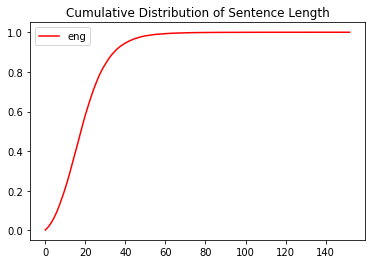

In [28]:
text=data[:,0]
import collections
import numpy as np
import matplotlib.pyplot as plt
def len_dis(text):
  lens = [len(line) for line in text]
  len_counter = collections.Counter(lens)

  lens = np.array(list(len_counter.keys()))
  sort_idx = np.argsort(lens)
  lens_sort = lens[sort_idx]
  len_counts = np.array(list(len_counter.values()))
  len_counts_sort = len_counts[sort_idx]
  p = np.cumsum(len_counts_sort) / len_counts_sort.sum()
  return p, lens_sort
  
src_p, src_lens_sort = len_dis(text)
plt.plot(src_lens_sort, src_p, 'r-', label='eng')
plt.title('Cumulative Distribution of Sentence Length')
plt.legend()
plt.show()

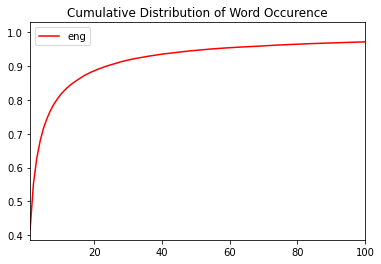

In [29]:
def len_dis(text):
  words = [token for line in text for token in line]
  word_counter = collections.Counter(words)
  freq_counter=  collections.Counter(word_counter.values())
  freqs = np.array(list(freq_counter.keys()))
  freq_length = np.array(list(freq_counter.values()))
  sort_idx= np.argsort(freqs)
  freq_sort = freqs[sort_idx]
  freq_length = np.array(list(freq_counter.values()))
  freq_length_sort = freq_length[sort_idx]
  p = np.cumsum(freq_length_sort) / freq_length_sort.sum()
  return p, freq_sort
  
src_p, src_lens_sort = len_dis(text)
plt.plot(src_lens_sort, src_p, 'r-', label='eng')
plt.title('Cumulative Distribution of Word Occurence')
plt.legend()
axes = plt.gca()
axes.set_xlim([1,100])
plt.show()

In [0]:
MIN_FREQ=30
MAX_LEN=50

In [0]:
class Vocab():
  def __init__(self, name, tokens, min_freq):
    self.name = name
    self.index2word = {
      0: 'pad',
      1: 'unk'
    }
    self.word2index = {v: k for k, v in self.index2word.items()}
    self.num_word = 2
    token_freq = collections.Counter(tokens)
    tokens = [token for token in tokens if token_freq[token] >= MIN_FREQ]
    self._build_vocab(tokens)
    
  def _build_vocab(self, tokens):
    for token in tokens:
      if token not in self.word2index:
        self.word2index[token] = self.num_word
        self.index2word[self.num_word] = token
        self.num_word += 1
        
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.word2index.get(tokens, self.word2index['unk'])
    else:
      return [self.__getitem__(token) for token in tokens]

In [0]:
def build_vocab(name, tokens, min_freq):
  sentences=tokens[:,0]
  tokens = [token for sentence in sentences for token in sentence]
  return Vocab(name, tokens, min_freq)

def build_vocabs(lang_src, src_text):
  vocab_src = build_vocab(lang_src, src_text, MIN_FREQ)
  return vocab_src

def pad(line, padding_token):
  return line + [padding_token] * (MAX_LEN-len(line))

def build_tensor(text, reviews_vocab):
  labels=text[:,1]
  lines = [reviews_vocab[line] for line in text[:,0]]
  lst=[]
  for i in range(len(lines)):
    padded_sentence=torch.tensor(pad(lines[i],reviews_vocab['pad']))
    label=torch.tensor(labels[i])
    lst.append([padded_sentence,label])
  return lst

def load_reviews_data():
  reviews_vocab = build_vocabs('reviews', data)
  for i in range(len(data[:,0])):
    data[:,0][i]=data[:,0][i][:MAX_LEN]
  reviews_array = build_tensor(data, reviews_vocab)
  return reviews_vocab,reviews_array


#source, target = prepare_data(raw_text, max_len=MAX_LEN)
#vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size=2)
#print('Vocabulary size of source language: {}'.format(vocab_eng.num_word))
#print('Vocabulary size of target language: {}'.format(vocab_fra.num_word))
#print('Total number of sentence pairs: {}'.format(len(source)))

In [0]:
reviews_vocab,reviews_array=load_reviews_data()

In [0]:
#CRAN used with Pytorch embedding
class CRAN(nn.Module):
  def __init__(self,vocab_size,embedding_size,cnn_window_length,hidden_units,p_dropout):
    super(CRAN, self).__init__()

    """
    inputs:
      cnn_num_filters: the number of convolutional kernels, represents the number of output channels parameter in Conv2d
      cnn_window_length: in a kernel size of d*l, d represents the embedding size and l represents the window length
      LSTM_hidden_units: number of hidden units in LSTM layer
      dropout: dropout probability for CNN
      embedding_size: length of embedded word vectors 
    """
    self.embedding=nn.Embedding(vocab_size,embedding_size)
    self.cnn=torch.nn.Conv2d(1,hidden_units,(cnn_window_length,embedding_size), padding=(1,0))
    self.dropout=torch.nn.Dropout(p_dropout)
    self.rnn=torch.nn.LSTM(embedding_size,hidden_units,1, batch_first=True)
    self.hidden_size = hidden_units
    self.dense = nn.Linear(hidden_units, 2)
  def forward(self,batch,labels):
    word_embedded=self.embedding(batch)
    (N,T,d)=word_embedded.shape
    word_embedded=word_embedded.view(N,1,T,d)
    #apply convolutional filters to the input sentences
    cnn_output=self.cnn(word_embedded)
    #cnn_output will be of shape (N,cnn_num_filters,H_out from Pytorch documentation,1)
    shape=cnn_output.shape
    cnn_output= F.relu(cnn_output.view(N,shape[1],shape[2]))
    #average across the different filter outputs
    cnn_output=torch.mean(cnn_output,1)
    h = batch.new_zeros(1, N, self.hidden_size).float()
    c = batch.new_zeros(1, N, self.hidden_size).float()
    word_embedded=word_embedded.view(N,T,d)
  
    lstm_out, (h,c) = self.rnn(word_embedded, (h, c))

    s = torch.mean(lstm_out * cnn_output.unsqueeze(2), 1)

    pred = F.log_softmax(self.dense(s))
    
    if self.training:
      loss = F.nll_loss(pred, labels)

      return loss, pred.argmax(dim=-1)
    else:
      return pred

In [0]:
# training CRAN with Pytorch embedding
reviews=torch.zeros((len(reviews_array),len(reviews_array[0][0])),dtype=torch.long)
labels=torch.zeros((len(reviews_array)),dtype=torch.long)
for i in range(len(reviews_array)):
  reviews[i]=torch.tensor(reviews_array[i][0])
  labels[i]=torch.tensor(reviews_array[i][1])

batch_size = 16
vocab_size=reviews_vocab.num_word
embedding_dim = 100
hidden_size = 100
cnn_window_length=3
lr = 1e-3
epoch = 10
p_dropout=0.5

CRAN_m = CRAN(vocab_size, embedding_dim, cnn_window_length,hidden_size,p_dropout)
device = torch.device('cuda:0') # cuda:0 if you have gpu
CRAN_m = CRAN_m.to(device)

optimizer = torch.optim.Adam(CRAN_m.parameters(), lr=lr)
loss_list = []
for e in range(epoch):
  CRAN_m.train()
  permutation=torch.randperm(reviews.size()[0])
  for i in range(0,reviews.size()[0],batch_size):
    indices = permutation[i:i+batch_size]
    reviews_batch, labels_batch = reviews[indices], labels[indices]
    reviews_batch=reviews_batch.to(device)
    labels_batch=labels_batch.to(device)
    loss, pred = CRAN_m(reviews_batch,labels_batch)
    loss_list.append(loss.mean().detach())
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    if i%5000==0:
      print(loss.mean())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


KeyboardInterrupt: 

In [0]:
embed_model = Word2Vec(size=300, min_count=1)
embed_model.build_vocab(data[:,0])
total_examples = embed_model.corpus_count
pretrained = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
embed_model.build_vocab([list(pretrained.vocab.keys())], update=True)
embed_model.intersect_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
embed_model.train(data[:,0], total_examples=total_examples, epochs=embed_model.iter)

/anaconda3/lib/python3.7/site-packages/gensim/models/base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [0]:
embed_model.wv.save('embedding_model')

In [0]:
class GoogleEmbedding(nn.Module):
  def __init__(self, model_path):
    super(GoogleEmbedding, self).__init__()

    # Load Google's pre-trained Word2Vec model.
    self.model = KeyedVectors.load(model_path, mmap='r')

  def forward(self, batch):
    out = []
    for sent in batch:
      sent_embed = []
      for word in sent:
        sent_embed.append(self.model[word])
      
      sent_embed = np.array(sent_embed)
      out.append(sent_embed)
    return np.array(out)

In [0]:
embedding = GoogleEmbedding('./drive/My Drive/embedding_model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
del_lst=[]
for i in range(len(data)):
    if len(data[:,0][i])==0:
        del_lst.append(i)
data=np.delete(data,del_lst,axis=0)

In [0]:
for i in range(len(data)):
    data[:,0][i]=data[:,0][i][:MAX_LEN]

In [0]:
reviews_array=embedding(data[:,0])

In [0]:
for i in range(len(reviews_array)):
    print(i)
    avg_vector=np.reshape(np.repeat(np.reshape(np.average(reviews_array[i],axis=0),(1,300)),MAX_LEN-len(reviews_array[i]),axis=0),(MAX_LEN-len(reviews_array[i]),300))
    reviews_array[i]=np.concatenate((reviews_array[i],avg_vector),axis=0)

In [0]:
#CRAN used with word2vec embedding
class CRANword2vec(nn.Module):
  def __init__(self,embedding_size,cnn_window_length,hidden_units,p_dropout):
    super(CRANword2vec, self).__init__()

    """
    inputs:
      cnn_num_filters: the number of convolutional kernels, represents the number of output channels parameter in Conv2d
      cnn_window_length: in a kernel size of d*l, d represents the embedding size and l represents the window length
      LSTM_hidden_units: number of hidden units in LSTM layer
      dropout: dropout probability for CNN
      embedding_size: length of embedded word vectors 
    """
    self.cnn=torch.nn.Conv2d(1,hidden_units,(cnn_window_length,embedding_size), padding=(1,0))
    self.dropout=torch.nn.Dropout(p_dropout)
    self.rnn=torch.nn.LSTM(embedding_size,hidden_units,1, batch_first=True)
    self.hidden_size = hidden_units
    self.dense = nn.Linear(hidden_units, 2)
  def forward(self,batch,labels):
    (N,T,d)=batch.shape
    batch=batch.view(N,1,T,d)
    #apply convolutional filters to the input sentences
    cnn_output=self.cnn(batch)
    #cnn_output will be of shape (N,cnn_num_filters,H_out from Pytorch documentation,1)
    shape=cnn_output.shape
    cnn_output= F.relu(cnn_output.view(N,shape[1],shape[2]))
    #average across the different filter outputs
    cnn_output=torch.mean(cnn_output,1)
    h = batch.new_zeros(1, N, self.hidden_size).float()
    c = batch.new_zeros(1, N, self.hidden_size).float()
    batch=batch.view(N,T,d)
  
    lstm_out, (h,c) = self.rnn(batch, (h, c))

    s = torch.mean(lstm_out * cnn_output.unsqueeze(2), 1)

    pred = F.log_softmax(self.dense(s))
    
    if self.training:
      loss = F.nll_loss(pred, labels)

      return loss, pred.argmax(dim=-1)
    else:
      return pred

In [0]:
# training CRAN with word2vec embedding
reviews=torch.zeros((len(reviews_array),reviews_array[0].shape[0],reviews_array[0].shape[1])).float()
labels=torch.zeros((len(reviews_array)),dtype=torch.long)
for i in range(len(reviews_array)):
    reviews[i]=torch.tensor(reviews_array[i])
    labels[i]=torch.tensor(data[:,1][i])

batch_size = 16
vocab_size=reviews_vocab.num_word
embedding_dim = 300
hidden_size = 100
cnn_window_length=3
lr = 1e-3
epoch = 10
p_dropout=0.5

CRAN_m = CRANword2vec(embedding_dim, cnn_window_length,hidden_size,p_dropout)
device = torch.device('cuda:0') # cuda:0 if you have gpu
CRAN_m = CRAN_m.to(device)

optimizer = torch.optim.Adam(CRAN_m.parameters(), lr=lr)
loss_list = []
for e in range(epoch):
    CRAN_m.train()
    permutation=torch.randperm(reviews.size()[0])
    for i in range(0,reviews.size()[0],batch_size):
        indices = permutation[i:i+batch_size]
        reviews_batch, labels_batch = reviews[indices], labels[indices]
        reviews_batch=reviews_batch.to(device)
        labels_batch=labels_batch.to(device)
        loss, pred = CRAN_m(reviews_batch,labels_batch)
        loss_list.append(loss.mean().detach())
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        if i%5000==0:
          print('Loss: '+str(loss.mean()))